In [1]:
import pandas as pd
import altair as alt
from altair import Bin

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

from confused import squares

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 1

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [========================

In [3]:
y_prob = model.predict(x_test)
y_classes = y_prob.argmax(axis=-1)
actual = y_test.argmax(axis=-1)

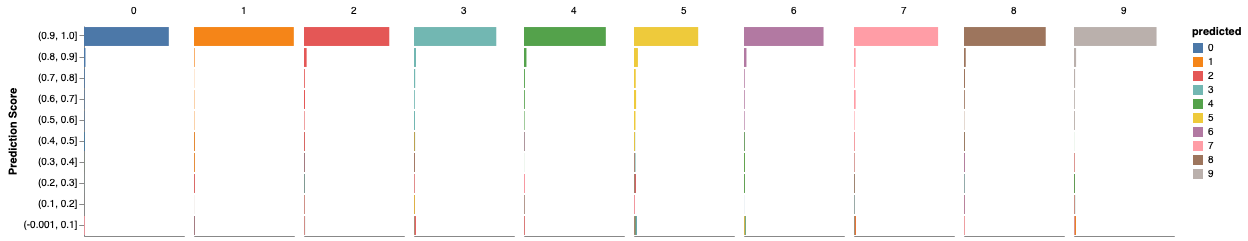

In [4]:
squares(y_prob, actual, y_classes)

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
clf = RandomForestClassifier().fit(x_train, y_train.argmax(axis=-1))

/Users/ignat/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [7]:
y_prob = clf.predict_proba(x_test)
y_classes = clf.predict(x_test)

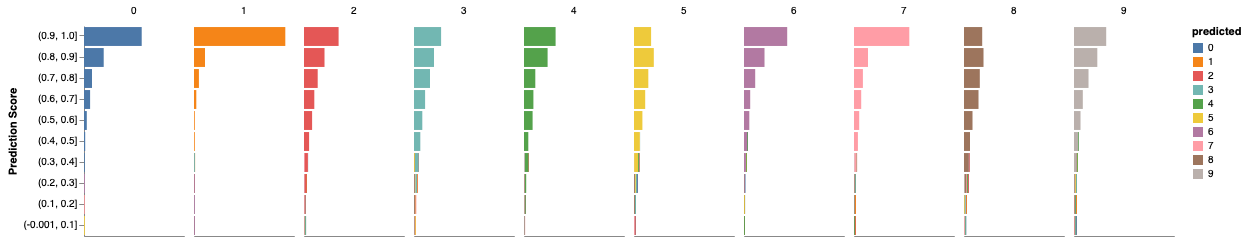

In [8]:
squares(y_prob, actual, y_classes)

# Ivis

In [5]:
import numpy as np
from ivis import Ivis

from keras.models import Model
from keras.layers import Input, Dense, AlphaDropout
from sklearn.decomposition import PCA

def create_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(500, activation='selu', kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.1)(x)
    x = Dense(500, activation='selu', kernel_initializer='lecun_normal')(inputs)
    x = AlphaDropout(0.1)(x)
    x = Dense(2000, activation='selu', kernel_initializer='lecun_normal')(inputs)
    return Model(inputs, x)

In [6]:
x_ivis = PCA(n_components=50).fit_transform(x_test)

In [7]:
ivis = Ivis(model = create_network((x_ivis.shape[1], )), epochs=5)
ivis.fit(x_ivis)

100%|██████████| 10000/10000 [00:00<00:00, 111534.62it/s]

Building KNN index


Extracting KNN from index


100%|██████████| 10000/10000 [00:03<00:00, 3128.99it/s]


Training neural network
Epoch 1/5
78/78 [==============================] - 2s 24ms/step - loss: 0.5056
Epoch 2/5
78/78 [==============================] - 1s 19ms/step - loss: 0.4230
Epoch 3/5
78/78 [==============================] - 1s 19ms/step - loss: 0.4249
Epoch 4/5
78/78 [==============================] - 1s 19ms/step - loss: 0.4104
Epoch 5/5
78/78 [==============================] - 1s 19ms/step - loss: 0.4026


Ivis(annoy_index_path='annoy.index', batch_size=128, distance='pn',
   embedding_dims=2, epochs=5, k=150, margin=1, model=None,
   n_epochs_without_progress=50, ntrees=50, precompute=True, search_k=-1)

In [8]:
embeddings = ivis.transform(x_ivis)
y_prob = model.predict(x_test)

In [9]:
xy_df = pd.DataFrame({'dim1': embeddings[:,0], 'dim2': embeddings[:,1], 'class': actual})
prob_df = pd.DataFrame(y_prob)
prob_df.columns.astype(str)

xy_df['id'] = xy_df.index.values
prob_df['id'] = prob_df.index.values
prob_df = prob_df.melt(id_vars=['id'])

In [10]:
prob_df.head()

,id,variable,value
0,0,0,2.049682e-07
1,1,0,5.801684e-08
2,2,0,1.151588e-06
3,3,0,9.967169e-01
4,4,0,2.806258e-06


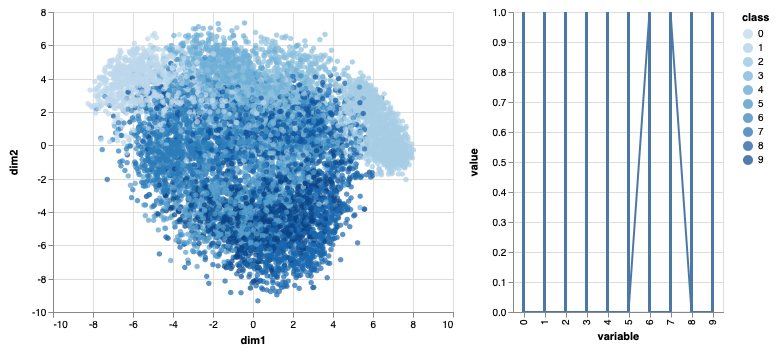

In [13]:
selector = alt.selection_single(empty='all', fields=['id'])
alt.data_transformers.enable('csv')

points = alt.Chart(xy_df).mark_circle().encode(
    x='dim1',
    y='dim2',
    color='class:O'
).add_selection(selector).interactive()

series = alt.Chart(prob_df).mark_line().encode(
    x='variable:O',
    y='value',    
).transform_filter(
    selector
)

points | series